[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kevin7261/Geographic-Data-Science-with-Python/blob/main/Local_Spatial_Autocorrelation_2.ipynb)

# Local Spatial Autocorrelation

https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

In [1]:
# @title 初始值設定

PROJECT_NAME = "15_台南市區_合併位置_2"
GEOJSON_NAME = "台南市區_2"

DENGUE_DAILY_GSHEET_PATH = "https://docs.google.com/spreadsheets/d/1vYyoq0Vf07kuWJU0Rg375jpHT9r9WzA2jiCPl3V3Oi4/edit?gid=2026372005#gid=2026372005"
GEOJSON_FILE_PATH = "https://drive.google.com/file/d/19HAcRgd1o3KYugAIgcnM3xKN6ybUQ2RX/view?usp=sharing"
WORKSHEET_NAME = PROJECT_NAME

In [2]:
# @title 下載台北思源黑體

# 下載台北思源黑體，並隱藏輸出
!wget -q -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 匯入必要的庫
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 新增字體
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')

# 設定字體
mpl.rc('font', family='Taipei Sans TC Beta')


In [3]:
# @title 安裝套件

!pip install -q geopandas gdown
!pip install -q pysal splot contextily
!pip install -q rioxarray rasterio xarray

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━

---

# An empirical illustration

In [4]:
# @title 匯入函式庫

import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn  # Graphics
import geopandas  # Spatial data manipulation
import pandas  # Tabular data manipulation
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles

/usr/local/lib/python3.11/dist-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


## 資料集

1. 2015年台南市登革熱病例 (sheet)
1. 台南市最小統計區 (shp)

In [5]:
# @title 載入2015年台南市登革熱病例(gsheet)

# ✅ 匯入套件
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from gspread_dataframe import get_as_dataframe

SPREADSHEET_ID_GSHEET = DENGUE_DAILY_GSHEET_PATH.split("/d/")[1].split("/")[0]

# ✅ 認證授權
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# ✅ 開啟工作表
sh = gc.open_by_key(SPREADSHEET_ID_GSHEET)
worksheet = sh.worksheet(WORKSHEET_NAME)

# ✅ 將工作表轉為 DataFrame
ref = get_as_dataframe(worksheet)  # 可加入 index_col="name" 如欄位存在

ref.set_index("name", inplace=True)

# ✅ 預覽資料
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 430 entries, A6737-15 to A0902-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   430 non-null    float64
dtypes: float64(1)
memory usage: 6.7+ KB


In [6]:
# @title 下載geojson

import gdown

# ✅ 從 Google Drive 分享連結中提取檔案 ID
file_id = GEOJSON_FILE_PATH.split("/d/")[1].split("/")[0]

# ✅ 建立 direct download 連結
download_url = f"https://drive.google.com/uc?id={file_id}"

# ✅ 執行下載（保留原始檔名）
gdown.download(download_url, quiet=False)  # 不指定 output，就會用原檔名

# ✅ 驗證是否下載成功
import os
downloaded_files = os.listdir()
print("📂 當前目錄檔案：", downloaded_files)

Downloading...
From: https://drive.google.com/uc?id=19HAcRgd1o3KYugAIgcnM3xKN6ybUQ2RX
To: /content/台南市區_2.geojson
100%|██████████| 1.35M/1.35M [00:00<00:00, 45.8MB/s]

📂 當前目錄檔案： ['.config', 'TaipeiSansTCBeta-Regular.ttf', '台南市區_2.geojson', 'sample_data']


In [7]:
# @title 載入台南市最小統計區(geojson)

lads = geopandas.read_file(
    f"{GEOJSON_NAME}.geojson",
).set_index("CODE2")
lads.info()

#print(lads.crs) # EPSG:4979 Geodetic 3D coordinate system

lads.set_crs(epsg=3826, inplace=True, allow_override=True) # EPSG:3826 TWD97

#print(lads.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 261 entries, A6733-22 to A6736-21
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   TOWN_ID    261 non-null    object  
 1   TOWN       261 non-null    object  
 2   COUNTY_ID  261 non-null    object  
 3   COUNTY     261 non-null    object  
 4   U_ID       261 non-null    int32   
 5   AREA       261 non-null    float64 
 6   X          261 non-null    float64 
 7   Y          261 non-null    float64 
 8   geometry   261 non-null    geometry
dtypes: float64(3), geometry(1), int32(1), object(4)
memory usage: 19.4+ KB


,TOWN_ID,TOWN,COUNTY_ID,COUNTY,U_ID,AREA,X,Y,geometry
CODE2,,,,,,,,,
A6733-22,67000330,南區,67000,臺南市,7365,191492.6060,167003.0921,2.541249e+06,"POLYGON Z ((167076.108 2541366.32 0, 167088.48..."
A6733-23,67000330,南區,67000,臺南市,7366,185313.8673,169361.5888,2.541144e+06,"POLYGON Z ((169587.61 2540975.821 0, 169592.04..."
A6733-24,67000330,南區,67000,臺南市,7367,120101.1382,166584.0934,2.541065e+06,"POLYGON Z ((166579.361 2541206.522 0, 166601.1..."
A6733-25,67000330,南區,67000,臺南市,7368,181941.0053,169124.5956,2.540906e+06,"POLYGON Z ((169138.085 2540995.219 0, 169129.7..."
A6735-06,67000350,安南區,67000,臺南市,7437,341483.5057,169816.9069,2.552237e+06,"POLYGON Z ((169838.781 2552696 0, 169845.656 2..."
...,...,...,...,...,...,...,...,...,...
A6736-17,67000360,安平區,67000,臺南市,7508,38127.9840,164752.9079,2.543379e+06,"POLYGON Z ((164909.162 2543357.209 0, 164902.4..."
A6736-18,67000360,安平區,67000,臺南市,7509,440990.0152,164989.4374,2.543164e+06,"POLYGON Z ((165400.084 2543351.506 0, 165381.3..."
A6736-19,67000360,安平區,67000,臺南市,7510,161597.3952,164524.5332,2.543141e+06,"POLYGON Z ((164737.321 2543143.53 0, 164729.82..."


# 分析count欄位

In [8]:
# @title 用index欄位合併csv與shp

db = (
    geopandas.GeoDataFrame(
        lads.join(ref[["count"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[ # EPSG:3857 Spherical Mercator
        ["count", "geometry"]
    ]
    #.dropna()
)

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 261 entries, A6733-22 to A6736-21
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   count     257 non-null    float64 
 1   geometry  261 non-null    geometry
dtypes: float64(1), geometry(1)
memory usage: 14.2+ KB


In [9]:
db["count"] = db["count"].fillna(0)  # ➤ 補 0

In [10]:
# # Set up figure and a single axis
# f, ax = plt.subplots(1, figsize=(9, 9))
# # Build choropleth
# db.plot(
#     column="count",
#     cmap="viridis",
#     scheme="quantiles",
#     k=5,
#     edgecolor="white",
#     linewidth=0.0,
#     alpha=0.75,
#     legend=True,
#     legend_kwds=dict(loc=2),
#     ax=ax,
# )
# # Add basemap
# contextily.add_basemap(
#     ax,
#     crs=db.crs,
#     source=contextily.providers.CartoDB.VoyagerNoLabels,
# )
# # Remove axes
# ax.set_axis_off();

scheme 名稱
說明
- "equal_interval" 等距分級：將值域平均分為 k 等級
- "quantiles" 分位數：依據排序後的分位數（例如四分位、五分位）劃分 k 等級
- "natural_breaks" Jenks Natural Breaks（自然斷點）法，最常用於地理資料
- "fisher_jenks" 類似 Jenks，但用 Fisher 的方式最小化群組內變異
- "headtail_breaks" 專為長尾分布設計，適合右偏態分布（常見於城市規模、人口數）
- "maximum_breaks" 嘗試最大化群組之間的差異（與 natural_breaks 相反）
- "std_mean" 標準差法，以平均值與標準差為基準分級
- "percentiles" 百分位分級，可微調分級分布（比 quantiles 更細）
- "box_plot" 使用 boxplot（Tukey’s method），分成如 Q1-Q3、極端值等
- "jenks_caspall" Jenks-Caspall 法改良版，比 natural breaks 更敏感
- "jenks_caspall_forced" 強迫分為 k 組的 Jenks-Caspall 法
- "user_defined" 使用者自定分級，需搭配 classification_kwds={"bins": [...]} 指定分級邊界


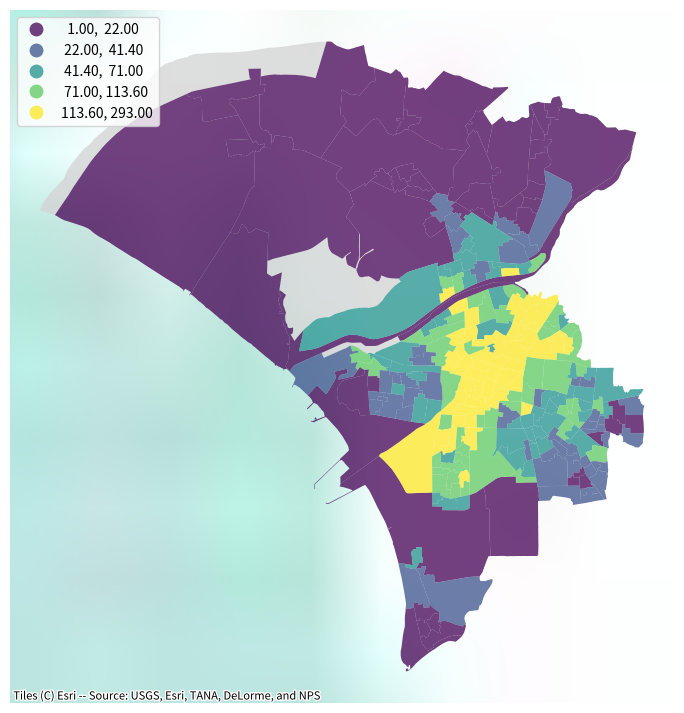

In [11]:
f, ax = plt.subplots(1, figsize=(9, 9))

# ✅ 先繪製 count 為 0 的區塊，顏色固定為灰色
db[db["count"] == 0].plot(
    color="lightgray",  # 固定灰色
    edgecolor="white",  # 邊界顏色
    linewidth=0.0,      # 無邊界線
    alpha=0.75,         # 半透明
    ax=ax               # 繪製在同一個 ax 上
)

# ✅ 再繪製 count > 0 的資料，使用分級色帶
db[db["count"] > 0].plot(
    column="count",                # 使用 count 欄位作為分級依據
    cmap="viridis",                # 色帶樣式
    scheme="quantiles",            # 使用分位數分級
    k=5,                           # 分成 5 等級
    edgecolor="white",             # 邊界顏色
    linewidth=0.0,                 # 無邊界線
    alpha=0.75,                    # 半透明
    legend=True,                   # 顯示圖例
    legend_kwds={"loc": 2},        # 圖例位置：左上角
    ax=ax                          # 繪製在同一個 ax 上
)


# ✅ 加入底圖（需要已投影為 Web Mercator）
contextily.add_basemap(
    ax,
    crs=db.crs,  # 使用原始資料的座標系統
    source=contextily.providers.Esri.WorldTerrain,  # 底圖來源
    zoom=6       # 底圖縮放層級
)

# ✅ 移除軸線
ax.set_axis_off()

In [12]:
# @title 使用8個最近鄰居

# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R" # ✅ 將空間權重矩陣 w 標準化為「行標準化（Row-standardized）」

# Motivating local spatial autocorrelation

In [13]:
db["w_count"] = weights.lag_spatial(w, db['count'])

In [14]:
db["count_std"] = db["count"] - db["count"].mean()
db["w_count_std"] = weights.lag_spatial(w, db['count_std'])

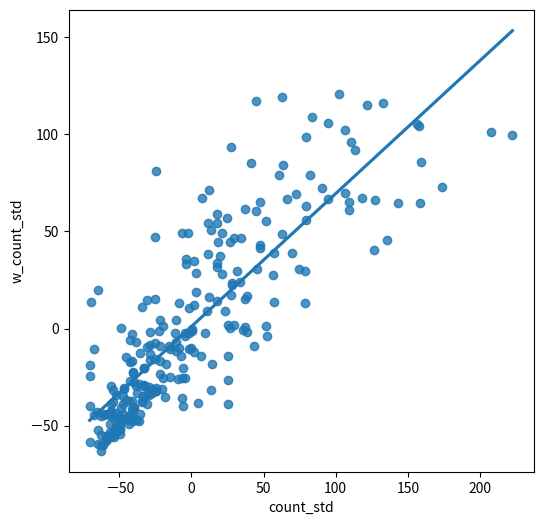

In [15]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="count_std", y="w_count_std", data=db, ci=None
)
plt.show()

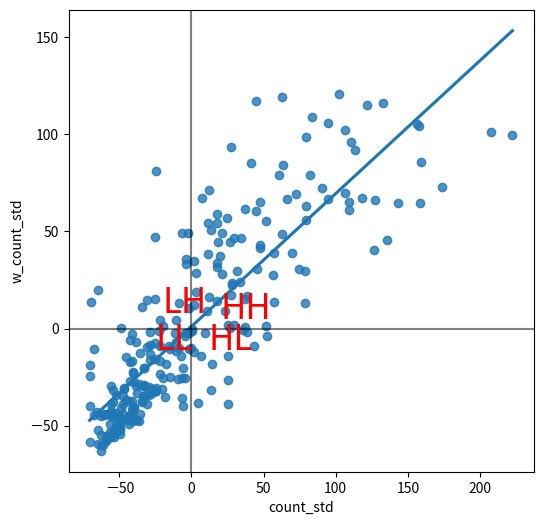

In [16]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="count_std", y="w_count_std", data=db, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r")
# Display
plt.show()

# Local Moran’s

In [17]:
lisa = esda.moran.Moran_Local(db["count"], w)

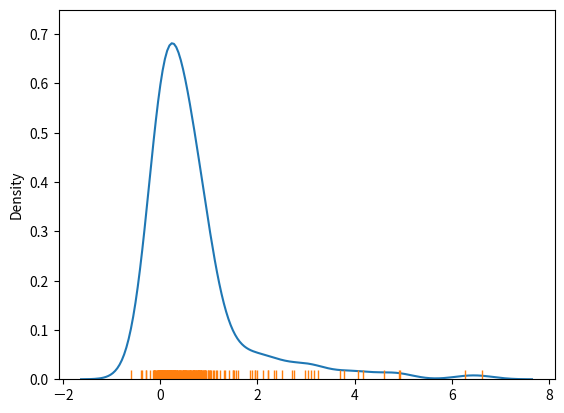

In [18]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

In [19]:
from splot import esda as esdaplot

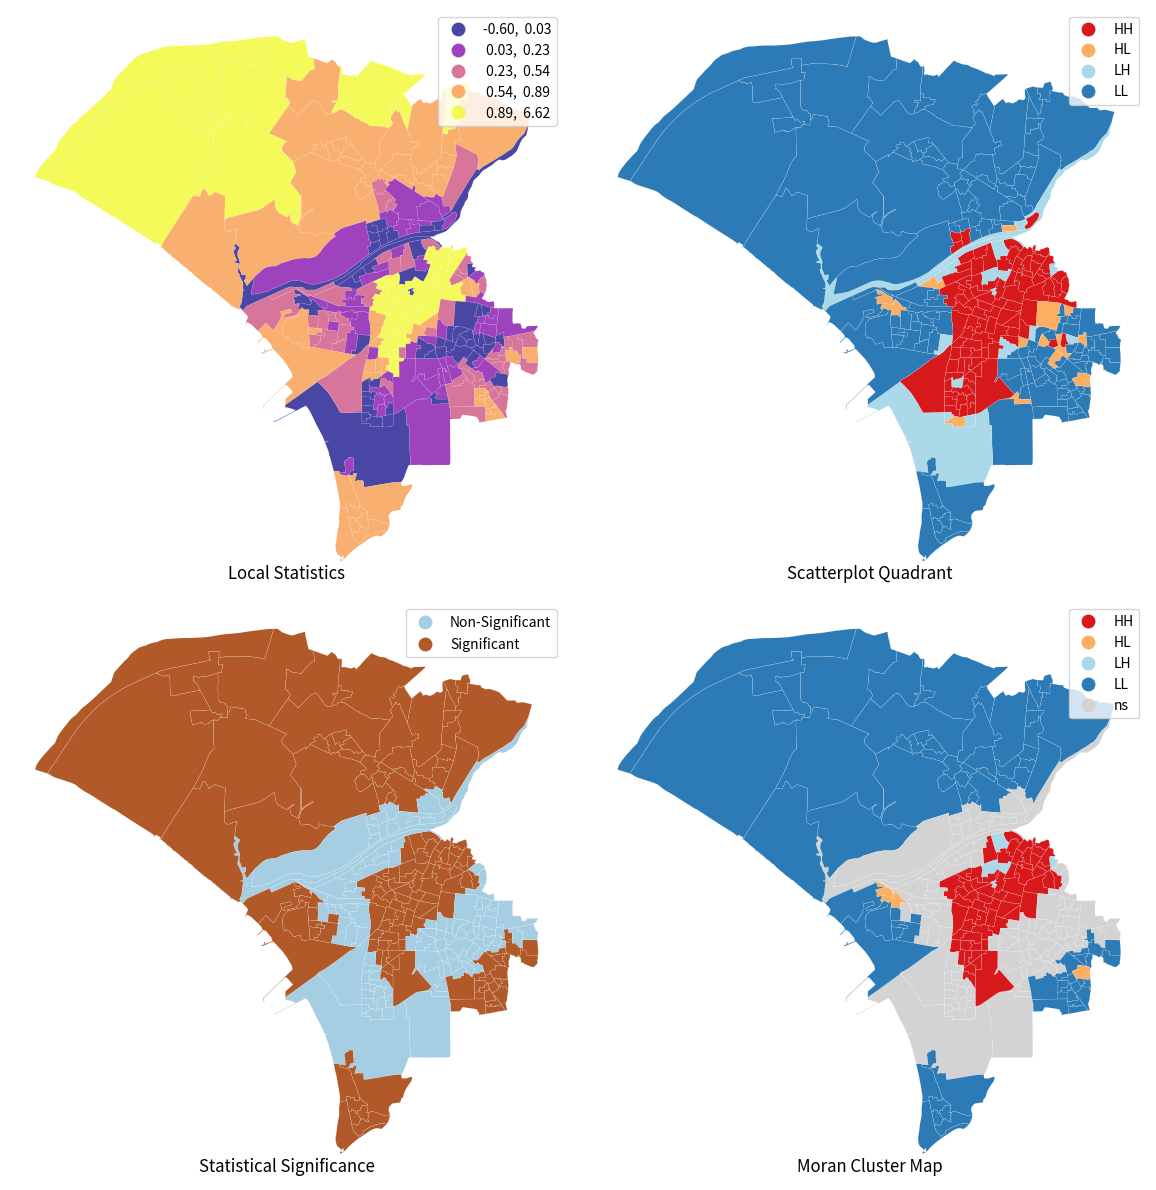

In [20]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [21]:
lisa.q[:10]

array([1, 3, 1, 4, 3, 3, 3, 3, 2, 3])

In [22]:
counts = pandas.value_counts(lisa.q)
counts

<ipython-input-22-210ba9165dbf>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pandas.value_counts(lisa.q)


,count
3,140
1,89
2,17
4,15


In [23]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

np.float64(56.70498084291188)

In [24]:
# Assign pseudo P-values to `db`
db["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
db["sig"] = sig
# Print top of the table to inspect
db[["sig", "p-sim"]].head()

,sig,p-sim
CODE2,,
A6733-22,0,0.211
A6733-23,0,0.159
A6733-24,0,0.098
A6733-25,0,0.193
A6735-06,1,0.001


In [25]:
# Print bottom of the table to inspect
db[["sig", "p-sim"]].tail()

,sig,p-sim
CODE2,,
A6736-17,1,0.016
A6736-18,1,0.015
A6736-19,1,0.004
A6736-20,0,0.123
A6736-21,0,0.419


In [26]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
db["labels"] = pandas.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=db.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
db["labels"].head()

,labels
CODE2,
A6733-22,Non-Significant
A6733-23,Non-Significant
A6733-24,Non-Significant
A6733-25,Non-Significant
A6735-06,LL


In [27]:
db["labels"].value_counts()

,count
labels,
Non-Significant,113
LL,82
HH,59
LH,4
HL,3


# Getis and Ord’s local statistics

In [28]:
# Gi
go_i = esda.getisord.G_Local(db["count"], w)
# Gi*
go_i_star = esda.getisord.G_Local(db["count"], w, star=True)

/usr/local/lib/python3.11/dist-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)


In [29]:
def g_map(g, db, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(
        ax,
        crs=db.crs,
        source=contextily.providers.Esri.WorldTerrain,
    )
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic for Pct of Leave votes", size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()
    return ax

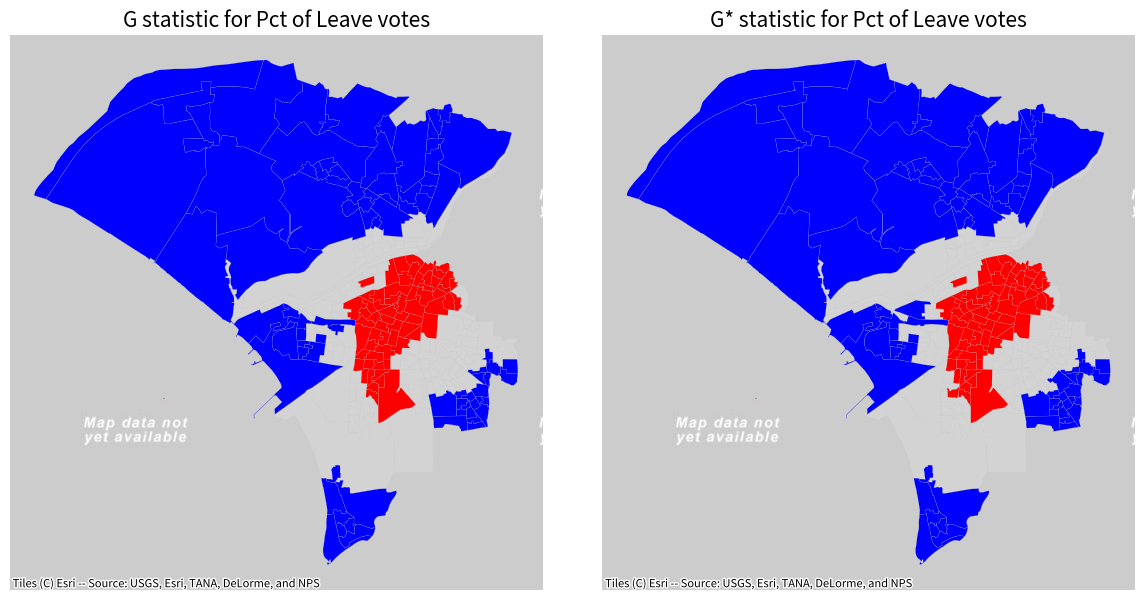

In [30]:
# Set up figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axs.flatten()):
    # Generate the statistic's map
    ax = g_map(g, db, ax)
# Tight layout to minimise blank spaces
f.tight_layout()
# Render
plt.show()

# Bonus: local statistics on surfaces

In [31]:
# Open GeoTIFF file and read into `xarray.DataArray`
pop = rioxarray.open_rasterio("https://drive.google.com/uc?export=download&id=1h_SMrjukGLzNHdghkOkmyycaIkFuw7sh") #("ghsl_sao_paulo.tif")


In [32]:
w_surface_sp = weights.Queen.from_xarray(pop)

In [33]:
w_surface_sp.sparse.dtype

dtype('int8')

In [34]:
type(w_surface_sp)

libpysal.weights.weights.WSP

In [35]:
import libpysal

libpysal.weights.weights.WSP

libpysal.weights.weights.WSP

In [36]:
w_surface_all = weights.WSP2W(  # 3.Convert `WSP` object to `W`
    weights.WSP(  # 2a.Build `WSP` from the float sparse matrix
        w_surface_sp.sparse.astype(
            float
        ),  # 1.Convert sparse matrix to floats
        id_order=w_surface_sp.index.tolist() # 2b. Ensure `W` is indexed
    )
)
w_surface_all.index = w_surface_sp.index  # 4.Assign index to new `W`

In [37]:
# Convert `DataArray` to a `pandas.Series`
pop_values = pop.to_series()
# Subset to keep only values that aren't missing
pop_values = pop_values[pop_values != pop.rio.nodata]

In [38]:
pop.rio.nodata

np.float32(-200.0)

In [39]:
w_surface = weights.w_subset(w_surface_all, pop_values.index)
w_surface.index = pop_values.index

In [40]:
# NOTE: this may take a bit longer to run depending on hardware
pop_lisa = esda.moran.Moran_Local(
    pop_values.astype(float), w_surface, n_jobs=-1
)

In [41]:
from libpysal.weights import raster

In [42]:
sig_pop = pandas.Series(
    pop_lisa.q
    * (
        pop_lisa.p_sim < 0.01
    ),  # Quadrant of significant at 1% (0 otherwise)
    index=pop_values.index,  # Index from the Series and aligned with `w_surface`
)

In [43]:
# Build `DataArray` from a set of values and weights
lisa_da = raster.w2da(
    sig_pop,  # Values
    w_surface,  # Spatial weights
    attrs={
        "nodatavals": [pop.rio.nodata]
    }  # Value for missing data
    # Add CRS information in a compliant manner
).rio.write_crs(pop.rio.crs)

In [44]:
lisa_da.to_series().unique()

array([-200,    0,    3,    1,    4,    2])

In [45]:
from matplotlib.colors import ListedColormap

In [46]:
# LISA colors
lc = {
    "ns": "lightgrey",  # Values of 0
    "HH": "#d7191c",  # Values of 1
    "LH": "#abd9e9",  # Values of 2
    "LL": "#2c7bb6",  # Values of 3
    "HL": "#fdae61",  # Values of 4
}

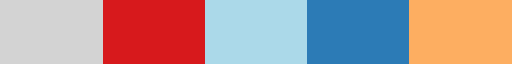

In [47]:
lisa_cmap = ListedColormap(
    [lc["ns"], lc["HH"], lc["LH"], lc["LL"], lc["HL"]]
)
lisa_cmap

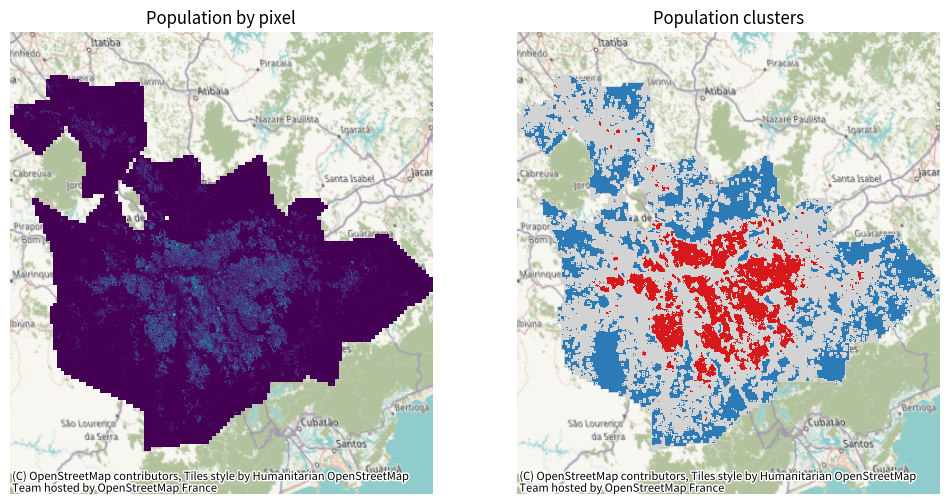

In [48]:
# Set up figure and axis
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Subplot 1 #
# Select pixels that do not have the `nodata` value
# (ie. they are not missing data)
pop.where(
    pop
    != pop.rio.nodata
    # Plot surface with a horizontal colorbar
).plot(
    ax=axs[0],
    add_colorbar=False,  # , cbar_kwargs={"orientation": "horizontal"}
)
# Subplot 2 #
# Select pixels with no missing data and rescale to [0, 1] by
# dividing by 4 (maximum value in `lisa_da`)
(
    lisa_da.where(lisa_da != -200)
    / 4
    # Plot surface without a colorbar
).plot(cmap=lisa_cmap, ax=axs[1], add_colorbar=False)
# Aesthetics #
# Subplot titles
titles = ["Population by pixel", "Population clusters"]
# Apply the following to each of the two subplots
for i in range(2):
    # Keep proportion of axes
    axs[i].axis("equal")
    # Remove axis
    axs[i].set_axis_off()
    # Add title
    axs[i].set_title(titles[i])
    # Add basemap
    contextily.add_basemap(axs[i], crs=lisa_da.rio.crs)